# MMAI 891 Tutorial on Word Embeddings

This tutorial includes 2 parts
1. Learning an embedding using Keras
2. Use a pre-trained word embeddings (GloVe)

We will then compare the accuarcy of our classification model between using our own word embeddings verses a pre-trained one (GloVe)

## Part 1 - Learning an Embedding in Keras

In [1]:
#Install packages if you haven't already
#!pip install -q keras
#!pip install -q tensorflow
#!pip install -q pyyaml 
#!pip install -q seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

C:\Users\st50\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#load the file
df = pd.read_csv('data/sentiment_train.csv', delimiter=',',encoding='latin-1')

In [4]:
#Preview the file
df.head()

,Sentence,Polarity
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


Text(0.5, 0, 'Label')

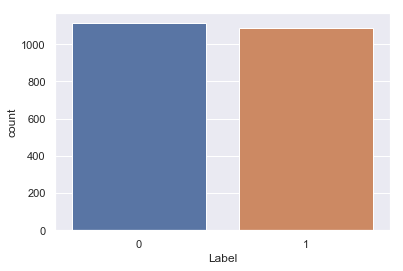

In [5]:
#See the distribution of the label

sns.set(style="darkgrid")
ax = sns.countplot(x="Polarity", data=df)
plt.xlabel('Label')

In [6]:
#Define the documents and the labels
X = df.Sentence
y = df.Polarity

le = LabelEncoder()
y = le.fit_transform(y)
y = y.reshape(-1,1)

In [7]:
#check dimensions of the labels
y.shape
y

(2202, 1)

array([[1],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]], dtype=int64)

In [8]:
#check dimensions of the do`cuments
X.shape
X[0:10,]

(2202,)

0                             Wow... Loved this place.
1                                   Crust is not good.
2            Not tasty and the texture was just nasty.
3    Stopped by during the late May bank holiday of...
4    The selection on the menu was great and so wer...
5       Now I am getting angry and I want my damn pho.
6                Honeslty it didn't taste THAT fresh.)
7    The potatoes were like rubber and you could te...
8                            The fries were great too.
9                                       A great touch.
Name: Sentence, dtype: object

In [76]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import unidecode

stop_words = set(stopwords.words('english'))
stop_words.remove("not")

lemmer = WordNetLemmatizer()

def preprocess(x):
    x = x.lower()
    
    x = re.sub(r'[^\w\s]', '', x)
    
    x = unidecode.unidecode(x)
    
    x = re.sub(r'\d+', '', x)
    
    x = [lemmer.lemmatize(w) for w in x.split() if w not in stop_words]

    return ' '.join(x)

X_bak = X.copy()
X = X.apply(preprocess)
X.head()

0                                      wow loved place
1                                       crust not good
2                              not tasty texture nasty
3    stopped late may bank holiday rick steve recom...
4                           selection menu great price
Name: Sentence, dtype: object

In [77]:
#Split data for test and train
X_train,X_test,y_train, y_test = train_test_split (X, y,  test_size=0.15, random_state=99) #remember to set a random_state for the split

Now that we have the document split between test and train, we can start building our word embedding

In [78]:
#Start with creating the sequence matrix

max_words = 1000 #to define vocab size for max num of words to keep based on word freq, here we are only keeping the 1000-1 most common words
max_len = 150 #to define fixed sequence length, here we are padding the input sequence to have the same length of 150

#vectorize the corpus
tok = Tokenizer(num_words=max_words) 
tok.fit_on_texts(X_train) #Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency
sequences = tok.texts_to_sequences(X_train) #Transforms each text in texts to a sequence of integers.
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len) #pad the vector so they are all the same length of 150

#we will use this sequences_matrix when we train the model

In [79]:
#check the dimension of our vectorized training data
sequences_matrix.shape 
sequences_matrix[0,:] #check if the array has the same elements as defined max_len of 150.  Yes? GOOD

(1871, 150)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0, 424, 234, 274,   2, 890,  18])

In [80]:
#Show the 1000 most frequent words included in the matrix
word_index = tok.word_index

In [81]:
#Find the index for 'happy'
word_index['happy']

82

In [82]:
# print the ids of the words in document 159
print ("sequences : ", sequences[159], '\n')

sequences :  [250, 703, 104, 24, 93] 



In [83]:
X_train.iloc[159]

'id advise anyone go see'

In [85]:
[tok.index_word[i] for i in sequences[159]]

['id', 'advise', 'anyone', 'go', 'see']

In [86]:
#define the Embedding layer as part of our neural network model
model1 = Sequential()

model1.add(Embedding(max_words, 32, input_length=max_len, mask_zero=False))
model1.add((LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model1.add(Dense(1, name='out_layer', activation='sigmoid'))

model1.summary()
model1.compile(loss='binary_crossentropy',optimizer=RMSprop(), metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 32)           32000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
out_layer (Dense)            (None, 1)                 65        
Total params: 56,897
Trainable params: 56,897
Non-trainable params: 0
_________________________________________________________________


In [87]:
#train the model
model1.fit(sequences_matrix, y_train, batch_size=128, epochs=10,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 1496 samples, validate on 375 samples
Epoch 1/10
1496/1496 [==============================] - 4s 3ms/step - loss: 0.6907 - acc: 0.5541 - val_loss: 0.6868 - val_acc: 0.5760
Epoch 2/10
1496/1496 [==============================] - 2s 2ms/step - loss: 0.6763 - acc: 0.6771 - val_loss: 0.6677 - val_acc: 0.6667
Epoch 3/10
1496/1496 [==============================] - 2s 2ms/step - loss: 0.6420 - acc: 0.7380 - val_loss: 0.6245 - val_acc: 0.7787
Epoch 4/10
1496/1496 [==============================] - 2s 2ms/step - loss: 0.5974 - acc: 0.7914 - val_loss: 0.5801 - val_acc: 0.7840
Epoch 5/10
1496/1496 [==============================] - 2s 2ms/step - loss: 0.5287 - acc: 0.8235 - val_loss: 0.5302 - val_acc: 0.7840
Epoch 6/10
1496/1496 [==============================] - 2s 2ms/step - loss: 0.4913 - acc: 0.8342 - val_loss: 0.4946 - val_acc: 0.8027
Epoch 7/10
1496/1496 [==============================] - 2s 1ms/step - loss: 0.4310 - acc: 0.8590 - val_loss: 0.4570 - val_acc: 0.8347
Epoch 8/10
1496

In [88]:
#set up the test set
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)

In [89]:
#show prediction: value closer to 1 is strong positive sentiment and value closer to 0 is a strong negative
predict_1 = model1.predict(x=test_sequences_matrix)

In [90]:
predict_1.shape

(331, 1)

In [91]:
#see the first 10 prediction
predict_1[0:10]

array([[0.15192512],
       [0.53643584],
       [0.7025749 ],
       [0.19202891],
       [0.9713885 ],
       [0.42433485],
       [0.89569753],
       [0.8787063 ],
       [0.64814806],
       [0.10122192]], dtype=float32)

In [92]:
#evaluate with test set
accr_1 = model1.evaluate(test_sequences_matrix, y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_1[0],accr_1[1]))

331/331 [==============================] - 0s 690us/step
Test set
  Loss: 0.452
  Accuracy: 0.758


In [93]:
sequences_matrix.shape
sequences_matrix[0]

(1871, 150)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0, 424, 234, 274,   2, 890,  18])

In [94]:
type(tok)
tok.document_count
tok.index_word[1]

keras_preprocessing.text.Tokenizer

1871

'not'

In [95]:
#show the learned embeddings 
embeds = model1.get_layer(index=0).get_weights()[0]
embeds.shape

(1000, 32)

In [96]:
#embedding for word 1

embeds[0]

array([ 0.03623868, -0.03221986, -0.04394674,  0.01576995, -0.02581737,
        0.00620955,  0.00877435,  0.03963459,  0.00567459,  0.00242022,
       -0.02872797, -0.01289139,  0.04647105, -0.03794513, -0.0528491 ,
        0.0020562 , -0.02260046, -0.0381529 ,  0.01511889,  0.00238416,
        0.02426012,  0.03637074,  0.02622405, -0.02957919,  0.02037595,
        0.04848439,  0.0317261 , -0.02074072, -0.00067305, -0.00518522,
        0.03326844, -0.04055934], dtype=float32)

In [97]:
#embedding for word 2
embeds[100]

array([ 0.00630081, -0.05250498, -0.00825288, -0.05047157, -0.06607118,
       -0.01574466, -0.03132604, -0.03279191, -0.00745375,  0.04764229,
       -0.06242871,  0.01799775,  0.03421138,  0.04111866,  0.05978788,
       -0.03788604,  0.00065762,  0.00821518,  0.07058298, -0.06028337,
       -0.03565179, -0.02640403, -0.03452161, -0.01225196, -0.02872601,
        0.03365713, -0.05572059,  0.01647411, -0.00650643, -0.00622066,
        0.02364117,  0.01745653], dtype=float32)

In [106]:
from sklearn.metrics.pairwise import cosine_similarity

sims =  cosine_similarity(embeds)
sims.shape
type(sims)

wid = tok.word_index['lunch']

ind = np.argpartition(sims[wid-1], -5)[-5:]
ind
sims[wid-1][ind]
[tok.index_word[i-1] for i in ind]

(1000, 1000)

numpy.ndarray

array([ 92,  67,  31, 216, 236], dtype=int64)

array([0.8882027 , 0.8912338 , 0.90777194, 0.8996068 , 0.9999999 ],
      dtype=float32)

['u', 'fit', 'love', 'crap', 'jabra']

In [102]:
tok.word_counts

OrderedDict([('sweet', 5),
             ('potato', 9),
             ('fry', 8),
             ('good', 162),
             ('seasoned', 2),
             ('well', 58),
             ('ambience', 3),
             ('perfect', 12),
             ('ive', 51),
             ('never', 38),
             ('treated', 2),
             ('bad', 43),
             ('show', 5),
             ('samsung', 5),
             ('warm', 6),
             ('beer', 7),
             ('didnt', 26),
             ('help', 5),
             ('comfortable', 16),
             ('cumbersome', 2),
             ('design', 11),
             ('nice', 37),
             ('headphone', 6),
             ('price', 36),
             ('work', 80),
             ('great', 153),
             ('best', 58),
             ('headset', 50),
             ('ever', 53),
             ('dont', 60),
             ('waste', 20),
             ('one', 85),
             ('yet', 7),
             ('plantronincs', 1),
             ('continues', 1),
             

### A quick aside: cosine similarity 

Using TF-IDF Vectorizer in Sklearn, calculate the cosine similarity between each record

In [ ]:
#using the first 5 sentences as an example
documents = (X[0:5,])
documents

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#transform documents into TF-IDF matrix

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

#show the dimension of the tfidf_matrix
print (tfidf_matrix.shape)

In [ ]:
#Take a look at the vector for the 1st sentense
print(tfidf_matrix[0])

In [ ]:
from scipy.spatial.distance import cosine


e1 = 

cosine_similarity(tfidf_matrix[0], tfidf_matrix)

In [ ]:
#compare how similar these 5 sentences are
cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
######IGNORE#####

from sklearn.metrics.pairwise import cosine_similarity

print("sequences_matrix for happy : " ,'\n', sequences_matrix[word_index['happy'],:], '\n')
print("sequences_matrix for sad : ",'\n', sequences_matrix[word_index['sad'],:], '\n')

x=(sequences_matrix[word_index['happy'],:]).reshape(1, -1)
y=sequences_matrix[word_index['sad'],:].reshape(1,-1)

cosine_similarity(x,y)

## Part 2 - Using pre-trained Embedding - GloVe

GloVe stands for Global Vectors for Word Representation

Download pre-trained word embeddings from https://nlp.stanford.edu/projects/glove/

In [ ]:
#Same as before
#Start with creating the sequence matrix

max_words = 1000 #to define vocab size for max num of words to keep based on word freq, here we are only keeping the 1000-1 most common words
max_len = 150 #to define fixed sequence length, here we are padding the input sequence to have the same length of 150

#vectorize the corpus
tok = Tokenizer(num_words=max_words) 
tok.fit_on_texts(X_train) #Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency
sequences = tok.texts_to_sequences(X_train) #Transforms each text in texts to a sequence of integers.
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len) #pad the vector so they are all the same length of 150

In [ ]:
sequences_matrix.shape

In [ ]:
len(tok.word_index)

In [ ]:
tok.word_index['happy']

In [ ]:
#load the GloVe word embedding into memory
embeddings_index = dict()
f = open ('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Loaded %s word vectors.' % len(embeddings_index))

In [ ]:
#See the 100 dimensions vector for "happy" and "the" in GloVe
embeddings_index.get("happy")
embeddings_index.get("the")

In [ ]:
word_index.items()

In [ ]:
#build the embedding matrix for words in training set

embedding_matrix = np.zeros((len(word_index) + 1, 100), dtype='float32')
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix

In [ ]:
#check dimension of the embedding_matrix : should be 1000 x 100 (1000 most frequent words and 100D vector from Glove)
embedding_matrix.shape

In [ ]:
#build the neural network model
model2 = Sequential()

#the only difference here is we use the embedding_matrix from previous step for the input layer
model2.add(Embedding(len(word_index)+1, 
                     100, 
                     weights=[embedding_matrix], 
                     input_length=max_len, 
                     trainable=False))
model2.add((LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model2.add(Dense(1, name='out_layer', activation='sigmoid'))

model2.summary()
model2.compile(loss='binary_crossentropy',optimizer=RMSprop(), metrics=['accuracy'])

In [ ]:
#train the model
model2.fit(sequences_matrix, y_train, batch_size=128, epochs=10,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

In [ ]:
#set up the test set
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)

In [ ]:
#show prediction: value closer to 1 is strong positive sentiment and value closer to 0 is a strong negative
predict_2 = model2.predict(x=test_sequences_matrix)

In [ ]:
predict_2.shape

In [ ]:
#see the first 10 predictions
predict_2[0:10]

In [ ]:
#Let's compare the prediction with the actual label
print (X_test[0:10])

for i in range(10):
    print ('Model predicted: ', predict_2[i],  'Actual score: ', y_test[i], '\n')

In [ ]:
#evaluate with test set
accr_2 = model2.evaluate(test_sequences_matrix, y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_2[0],accr_2[1]))

In [ ]:
#Recall accuracy from previous model using our own embeddings 

accr_1 = model1.evaluate(test_sequences_matrix, y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_1[0],accr_1[1]))

Here we can see that the model using the pre-trained embeddings does not do as well as the one we built as part of our neural network.